# Install dependencies

In [ ]:
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 207.5/207.5 MB 193.4 MB/s eta 0:00:01

# Importing Libraries

In [ ]:
import os, time, copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import timm

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Load Preprocessed Dataset

Function to get a dataset, its dataloaders, and number of classes

**Args:**
- name (str): The name of the dataset ('mnist', 'fmnist', 'fashionmnist', 'cifar10')
- batch_size (int): The desired batch size for the dataloaders
- data_dir (str): The directory to store/load the dataset (defaults to './data')

**Returns:**
- tuple: (train_loader, val_loader, num_classes)

In [ ]:
def get_dataset(name, batch_size, data_dir='./data'):
    if name.lower() != 'cifar10':   # Convert the dataset name to lowercase and check it for 'cifar10'
        raise ValueError(f"Unsupported dataset: {name}")

    # Define a sequence of transformations to apply to CIFAR10 images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # CIFAR10 images are already 32x32, so no Resize is needed here
        transforms.ToTensor(), # Convert images to PyTorch tensors
        # Normalize pixel values using CIFAR10's mean and std for RGB channels
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])
    num_classes = 10
    cls = torchvision.datasets.CIFAR10    # Get the CIFAR10 dataset class
    in_channels = 3

    train = cls(root=data_dir, train=True, download=True, transform=transform)   # Load the training dataset
    val = cls(root=data_dir, train=False, download=True, transform=transform)    # Load the validation/test dataset

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)    # Create a DataLoader for the training set
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=4)   # Create a DataLoader for the validation/test set

    # Return the training dataloader, validation dataloader, and the number of classes
    return train_loader, val_loader, in_channels, num_classes

# Model Factory

Function to get a neural network model instance

**Args:**
- name (str): The name of the model ('lenet5', 'alexnet', 'resnet', etc.)
- num_classes (int): The number of output classes for the classification layer
- pretrained (bool): Whether to load pretrained weights (defaults to False)

**Returns:**
- torch.nn.Module: An instance of the requested model

In [ ]:
from torchvision import models as tv_models
import timm
import torch.nn as nn

# (1) LeNet5 at module scope
class LeNet5(nn.Module):
    def __init__(self, in_ch: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 6, kernel_size=5), nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),
            nn.AvgPool2d(2),
            nn.AdaptiveAvgPool2d((5, 5)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Tanh(),
            nn.Linear(120, 84), nn.Tanh(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))


# (2) Model factory
def get_model(name: str, in_ch: int, num_classes: int, pretrained: bool=False) -> nn.Module:
    """
    Factory to return a model by name.

    Supported names:
      • lenet5
      • alexnet, vgg16, googlenet  (via torchvision)
      • resnet18, xception, senet   (via timm)
    """
    name = name.lower()

    # 1) Custom
    if name == 'lenet5':
        return LeNet5(in_ch, num_classes)

    # 2) GoogLeNet (no .features)
    if name == 'googlenet':
        model = tv_models.googlenet(pretrained=pretrained, aux_logits=False)
        # adjust input channels
        if in_ch != 3:
            model.conv1 = nn.Conv2d(
                in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False
            )
        # replace final fc
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model

    # 2) Torchvision models
    tv_map = {
        'alexnet':   tv_models.alexnet,
    }
    if name in tv_map:
        model = tv_map[name](pretrained=pretrained)

        # Adjust input channels if needed
        if in_ch != 3:
            first_conv = model.features[0]
            model.features[0] = nn.Conv2d(
                in_ch, first_conv.out_channels,
                kernel_size=first_conv.kernel_size,
                stride=first_conv.stride,
                padding=first_conv.padding,
                bias=first_conv.bias is not None
            )
        else:
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

        return model

    # 3) Timm models
    timm_map = {
        'resnet':     'resnet18',
        'resnet18':   'resnet18',
    }

    if name in timm_map:
        return timm.create_model(
            timm_map[name],
            pretrained=pretrained,
            in_chans=in_ch,
            num_classes=num_classes
        )

    # 4) Not found
    valid = ['lenet5'] + sorted(tv_map.keys()) + sorted(timm_map.keys())
    raise ValueError(f"Model '{name}' not recognized. Valid options: {valid}")

# Train / Eval Functions

In [ ]:
# Function to train the model for a single epoch
def train_one_epoch(
    model: nn.Module,
    device: torch.device,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer):

    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The model to train.
        device (torch.device): Device to use ('cuda' or 'cpu').
        loader (DataLoader): DataLoader providing training data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.

    Returns:
        float: Average training loss over the epoch.
    """

    model.train()       # Set the model to training mode (enables dropout, batchnorm updates, etc.)
    total_loss = 0.0    # Initialize variable to accumulate loss over the epoch

    # Iterate over the training data batches using the provided loader, tqdm adds a progress bar for the loop
    for X, y in tqdm(loader, desc='Training', leave=False):
        X, y = X.to(device), y.to(device)   # Move input features (X) and labels (y) to the specified device

        # Zero the gradients of the optimizer before computing gradients for the current batch
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs through the model
        outputs = model(X)

        # Calculate the loss between predicted outputs and true labels
        loss = criterion(outputs, y)

        loss.backward() # Backward pass: Compute gradient of the loss with respect to model parameters
        optimizer.step() # Optimizer step: Update the model's parameters using the computed gradients

        # Accumulate the batch loss, scaled by the number of samples in the batch loss.item() gets the scalar value of the loss tensor
        total_loss += loss.item() * X.size(0)

    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss # Return the average training loss for the epoch

# Function to evaluate the model on a dataset (validation or test)
def evaluate(
    model: nn.Module,
    device: torch.device,
    loader: DataLoader,
    criterion: nn.Module
):
    """
    Evaluates the model on a validation or test set.

    Args:
        model (nn.Module): The model to evaluate.
        device (torch.device): Device to use ('cuda' or 'cpu').
        loader (DataLoader): DataLoader providing evaluation data.
        criterion (nn.Module): Loss function.

    Returns:
        tuple: Average loss, accuracy, precision, recall, F1-score, (true targets, predictions).
    """
    model.eval()    # Set the model to evaluation mode (disables dropout, uses running stats for batchnorm, etc.)
    total_loss = 0.0    # Initialize variable to accumulate loss
    all_preds, all_targets = [], []   # Lists to store all predictions and true labels for metric calculation

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Iterate over the evaluation data batches using the provided loader
        # tqdm adds a progress bar for the loop
        for X, y in tqdm(loader, desc='Evaluating', leave=False):
            X, y = X.to(device), y.to(device) # Move input features (X) and labels (y) to the specified device

            # Forward pass: Compute predicted outputs
            out = model(X)

            # Calculate the batch loss and accumulate it
            batch_loss = criterion(out, y)
            total_loss += batch_loss.item() * X.size(0)

            # Get the predicted class index for each sample in the batch
            # argmax(dim=1) finds the index of the max value along dimension 1 (the class dimension)
            preds = out.argmax(dim=1)

            # Extend the lists with predictions and true labels, moving them back to CPU and converting to numpy
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Calculate the average loss over the dataset
    avg_loss = total_loss / len(loader.dataset)

    # Calculate evaluation metrics using scikit-learn
    acc = accuracy_score(all_targets, all_preds) # Overall accuracy

    # Precision, Recall, F1-score. 'weighted' averages metrics for each class, weighted by support.
    prec, rec, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')

    # Return the calculated metrics and the full lists of targets and predictions
    return avg_loss, acc, prec, rec, f1, (all_targets, all_preds)

# Plotting Utility

Function to plot training/validation loss and validation accuracy over epochs

**Args:**
- history (dict): Dictionary containing lists of metrics like 'train_loss', 'val_loss', 'val_acc'
- title (str): A string to use as a base for the plot titles

In [ ]:
def plot_metrics(history, title):
    # Determine the number of epochs from the length of the training loss list
    epochs = len(history['train_loss'])

    # --- Plot Loss ---
    plt.figure(); # Create a new figure for the loss plot
    # Plot the training loss
    plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
    # Plot the validation loss
    plt.plot(range(1, epochs+1), history['val_loss'],   label='Val Loss')
    # Set the title for the loss plot
    plt.title(f'{title} Loss');
    # Label the x-axis
    plt.xlabel('Epoch');
    # Display the legend
    plt.legend();
    # Show the loss plot
    plt.show()

    # --- Plot Accuracy ---
    plt.figure(); # Create a new figure for the accuracy plot
    # Plot the validation accuracy
    plt.plot(range(1, epochs+1), history['val_acc'],   label='Val Acc')
    # Set the title for the accuracy plot
    plt.title(f'{title} Accuracy');
    # Label the x-axis
    plt.xlabel('Epoch');
    # Display the legend
    plt.legend();
    # Show the accuracy plot
    plt.show()

# Experiment Runner

Main function to run a training and evaluation experiment

**Args:**
- dataset (str): Name of the dataset to use (default: 'cifar10')
- model_name (str): Name of the model architecture (default: None)
- pretrained (bool): Whether to use a pretrained model (default: False)
- epochs (int): Number of training epochs (default: 5)
- batch_size (int): Batch size for data loaders (default: 64)
- lr (float): Learning rate for the optimizer (default: 0.01)

**Returns:**
- torch.nn.Module: The trained model

In [ ]:
def run_experiment(
    dataset='cifar10',
    model_name=None,
    pretrained: bool = False,
    epochs: int = 5,
    batch_size: int = 64,
    lr: float = 0.01,
    save_dir: str = './checkpoints'):
    """
    Run a full training experiment:
     - Loads data for `dataset`
     - Instantiates `model_name` (with `pretrained` weights) using in_ch from data
     - Trains for `epochs` epochs
     - Saves best model based on validation accuracy
     - Plots training/validation metrics
     - Prints a final classification report

    Returns the best-trained model (moved to CPU).
    """

    if not model_name:
      raise ValueError("`model_name` must be specified")

    os.makedirs(save_dir, exist_ok=True)
    # Device setup, determine the device to use (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True

    # Data loaders
    train_loader, val_loader, in_ch, num_classes = get_dataset(dataset, batch_size)
    print(f"Detected input channels: {in_ch}")

    # Model instantiation
    model = get_model(model_name, in_ch, num_classes, pretrained=pretrained)
    model = model.to(device)
    print(f"Model '{model_name}' instantiated with pretrained={pretrained} and moved to {device}.")

    # Loss, optimizer & scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # History containers
    history = {
        'train_loss': [], 'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    best_acc = 0.0
    best_model_wts = None
    best_ckpt_path = None

    # Training loop
    for epoch in range(1, epochs + 1):
        print(f"\n====Epoch {epoch}/{epochs}====")
        train_loss = train_one_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc, val_prec, val_rec, val_f1, (y_true, y_pred) = evaluate(model, device, val_loader, criterion)

        scheduler.step()  # for StepLR

        # Record history logs
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Checkpoint best
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            ckpt_name = f"{dataset}_{model_name}_best.pth"
            best_ckpt_path = os.path.join(save_dir, ckpt_name)
            torch.save(best_model_wts, best_ckpt_path)
            print(f"[INFO] New best (Acc={best_acc:.4f}) → saved to {best_ckpt_path}")

    # --- Load & evaluate best model ---
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    model = model.cpu()

    # Re‐evaluate on val set to get final preds/targets
    _, _, _, _, _, (y_true, y_pred) = evaluate(model, torch.device('cpu'), val_loader, criterion)

    # --- Plot & report ---
    plot_metrics(history, title=f"{dataset} - {model_name}")
    print("\nFinal Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    return model

# Example Usage

## lenet5

Training lenet5 on CIFAR-10 Dataset...
Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Detected input channels: 3
Model 'lenet5' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 2.1782 | Val Loss: 2.0160 | Val Acc: 0.2664 | Val F1: 0.2145
[INFO] New best (Acc=0.2664) → saved to ./checkpoints/cifar10_lenet5_best.pth

====Epoch 2/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.9514 | Val Loss: 1.8894 | Val Acc: 0.3359 | Val F1: 0.3094
[INFO] New best (Acc=0.3359) → saved to ./checkpoints/cifar10_lenet5_best.pth

====Epoch 3/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.8544 | Val Loss: 1.8170 | Val Acc: 0.3646 | Val F1: 0.3466
[INFO] New best (Acc=0.3646) → saved to ./checkpoints/cifar10_lenet5_best.pth

====Epoch 4/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.7923 | Val Loss: 1.7551 | Val Acc: 0.3890 | Val F1: 0.3760
[INFO] New best (Acc=0.3890) → saved to ./checkpoints/cifar10_lenet5_best.pth

====Epoch 5/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.7372 | Val Loss: 1.7070 | Val Acc: 0.4032 | Val F1: 0.3934
[INFO] New best (Acc=0.4032) → saved to ./checkpoints/cifar10_lenet5_best.pth


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


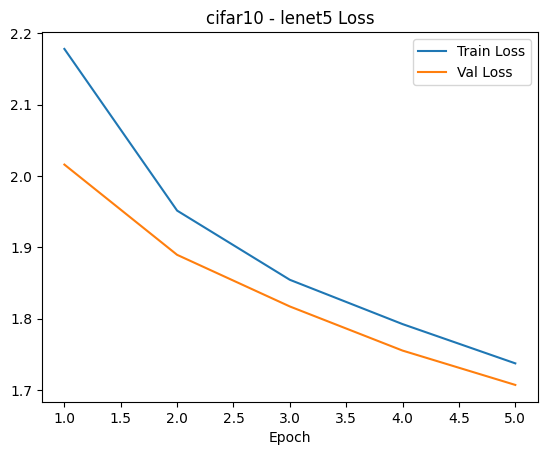

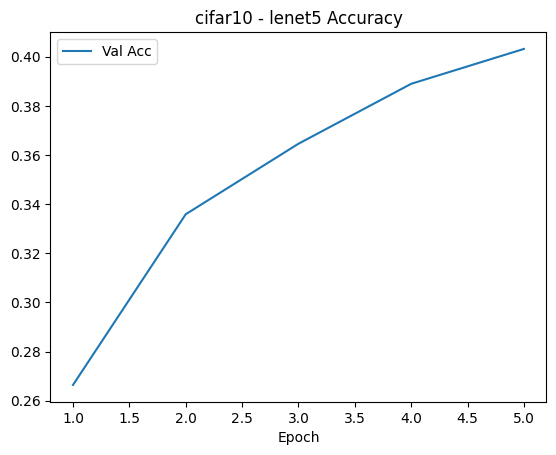


Final Classification Report:
              precision    recall  f1-score   support

           0     0.4817    0.4860    0.4838      1000
           1     0.4323    0.4920    0.4602      1000
           2     0.2955    0.2160    0.2496      1000
           3     0.3104    0.2080    0.2491      1000
           4     0.3716    0.3370    0.3534      1000
           5     0.3408    0.2600    0.2950      1000
           6     0.4057    0.6220    0.4911      1000
           7     0.3997    0.4600    0.4277      1000
           8     0.4552    0.5430    0.4952      1000
           9     0.4508    0.4080    0.4283      1000

    accuracy                         0.4032     10000
   macro avg     0.3944    0.4032    0.3934     10000
weighted avg     0.3944    0.4032    0.3934     10000

Finished training lenet5 on CIFAR-10 Dataset.


In [8]:
model_name = 'lenet5'
print(f"Training {model_name} on CIFAR-10 Dataset...")
# Reduced epochs for quick demos; adjust as needed
run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001)
print(f"Finished training {model_name} on CIFAR-10 Dataset.")

## alexnet

Training alexnet on CIFAR-10 Dataset...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Detected input channels: 3
Model 'alexnet' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 2.3023 | Val Loss: 2.3015 | Val Acc: 0.1390 | Val F1: 0.0700
[INFO] New best (Acc=0.1390) → saved to ./checkpoints/cifar10_alexnet_best.pth

====Epoch 2/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 2.2996 | Val Loss: 2.2892 | Val Acc: 0.1325 | Val F1: 0.0611

====Epoch 3/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 2.1104 | Val Loss: 1.9011 | Val Acc: 0.3086 | Val F1: 0.2586
[INFO] New best (Acc=0.3086) → saved to ./checkpoints/cifar10_alexnet_best.pth

====Epoch 4/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.7674 | Val Loss: 1.6119 | Val Acc: 0.4010 | Val F1: 0.3701
[INFO] New best (Acc=0.4010) → saved to ./checkpoints/cifar10_alexnet_best.pth

====Epoch 5/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.5893 | Val Loss: 1.4587 | Val Acc: 0.4647 | Val F1: 0.4447
[INFO] New best (Acc=0.4647) → saved to ./checkpoints/cifar10_alexnet_best.pth


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


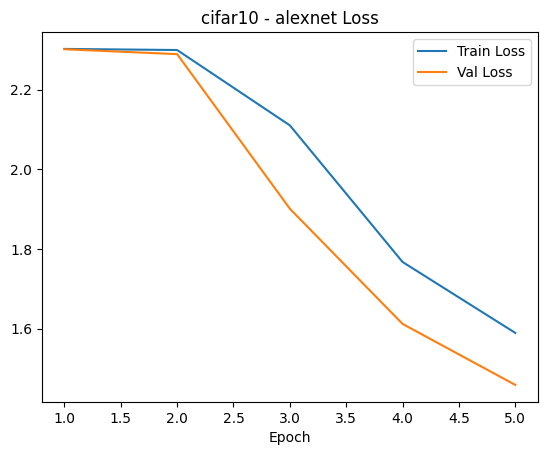

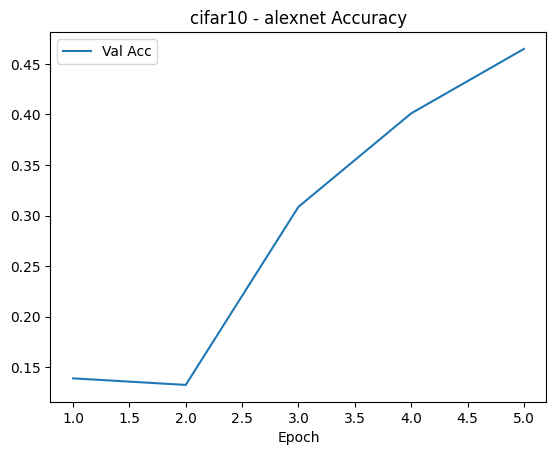


Final Classification Report:
              precision    recall  f1-score   support

           0     0.5369    0.3710    0.4388      1000
           1     0.6029    0.6180    0.6104      1000
           2     0.4099    0.1320    0.1997      1000
           3     0.3666    0.2240    0.2781      1000
           4     0.4517    0.2480    0.3202      1000
           5     0.3546    0.5890    0.4427      1000
           6     0.5036    0.6330    0.5609      1000
           7     0.4395    0.5770    0.4989      1000
           8     0.4657    0.6790    0.5525      1000
           9     0.5175    0.5760    0.5452      1000

    accuracy                         0.4647     10000
   macro avg     0.4649    0.4647    0.4447     10000
weighted avg     0.4649    0.4647    0.4447     10000

Finished training alexnet on CIFAR-10 Dataset.


In [9]:
# Train alexnet model on each datasets
model_name = 'alexnet'
print(f"Training {model_name} on CIFAR-10 Dataset...")
# Reduced epochs for quick demos; adjust as needed
run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001)
print(f"Finished training {model_name} on CIFAR-10 Dataset.")

## googlenet

Training googlenet on CIFAR-10 Dataset...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packa

Detected input channels: 3
Model 'googlenet' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 1.3540 | Val Loss: 1.2808 | Val Acc: 0.5642 | Val F1: 0.5472
[INFO] New best (Acc=0.5642) → saved to ./checkpoints/cifar10_googlenet_best.pth

====Epoch 2/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.8782 | Val Loss: 0.8309 | Val Acc: 0.7124 | Val F1: 0.7118
[INFO] New best (Acc=0.7124) → saved to ./checkpoints/cifar10_googlenet_best.pth

====Epoch 3/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.6428 | Val Loss: 0.6183 | Val Acc: 0.7846 | Val F1: 0.7835
[INFO] New best (Acc=0.7846) → saved to ./checkpoints/cifar10_googlenet_best.pth

====Epoch 4/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.5024 | Val Loss: 0.7004 | Val Acc: 0.7665 | Val F1: 0.7666

====Epoch 5/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.3954 | Val Loss: 0.7290 | Val Acc: 0.7581 | Val F1: 0.7643


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


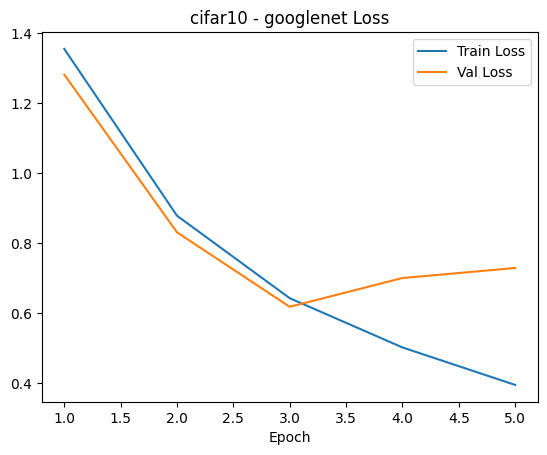

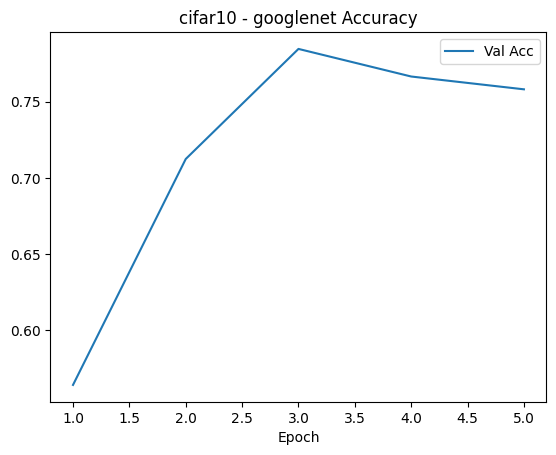


Final Classification Report:
              precision    recall  f1-score   support

           0     0.7303    0.8530    0.7869      1000
           1     0.9647    0.8210    0.8871      1000
           2     0.7797    0.6300    0.6969      1000
           3     0.6182    0.6720    0.6440      1000
           4     0.7680    0.7480    0.7579      1000
           5     0.8408    0.6340    0.7229      1000
           6     0.7727    0.8330    0.8017      1000
           7     0.7678    0.8830    0.8214      1000
           8     0.8604    0.8570    0.8587      1000
           9     0.8069    0.9150    0.8575      1000

    accuracy                         0.7846     10000
   macro avg     0.7910    0.7846    0.7835     10000
weighted avg     0.7910    0.7846    0.7835     10000

Finished training googlenet on CIFAR-10 Dataset.


In [10]:
# Train googlenet model on each datasets
model_name = 'googlenet'
print(f"Training {model_name} on CIFAR-10 Dataset...")
# Reduced epochs for quick demos; adjust as needed
run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001)
print(f"Finished training {model_name} on CIFAR-10 Dataset.")

## resnet

Training resnet18 on CIFAR-10 Dataset...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Detected input channels: 3
Model 'resnet18' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 1.9584 | Val Loss: 1.8443 | Val Acc: 0.3334 | Val F1: 0.3137
[INFO] New best (Acc=0.3334) → saved to ./checkpoints/cifar10_resnet18_best.pth

====Epoch 2/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.7999 | Val Loss: 1.7385 | Val Acc: 0.3589 | Val F1: 0.3372
[INFO] New best (Acc=0.3589) → saved to ./checkpoints/cifar10_resnet18_best.pth

====Epoch 3/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.7066 | Val Loss: 1.6675 | Val Acc: 0.4050 | Val F1: 0.3973
[INFO] New best (Acc=0.4050) → saved to ./checkpoints/cifar10_resnet18_best.pth

====Epoch 4/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.6380 | Val Loss: 1.6014 | Val Acc: 0.4254 | Val F1: 0.4152
[INFO] New best (Acc=0.4254) → saved to ./checkpoints/cifar10_resnet18_best.pth

====Epoch 5/5====


Training:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.5753 | Val Loss: 1.5701 | Val Acc: 0.4288 | Val F1: 0.4213
[INFO] New best (Acc=0.4288) → saved to ./checkpoints/cifar10_resnet18_best.pth


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


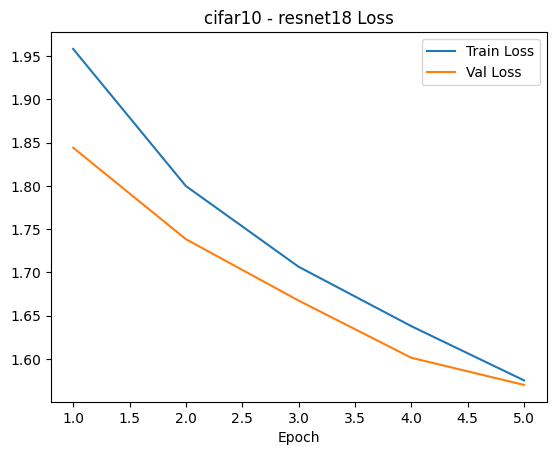

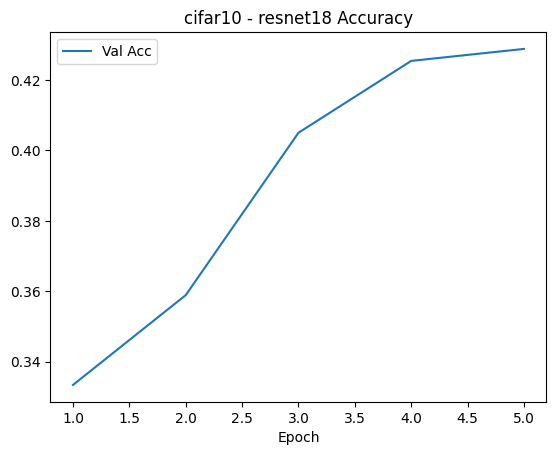


Final Classification Report:
              precision    recall  f1-score   support

           0     0.4556    0.5130    0.4826      1000
           1     0.5622    0.5240    0.5424      1000
           2     0.3581    0.2360    0.2845      1000
           3     0.2718    0.2150    0.2401      1000
           4     0.4101    0.2600    0.3182      1000
           5     0.3860    0.4520    0.4164      1000
           6     0.3741    0.6450    0.4736      1000
           7     0.4295    0.4510    0.4400      1000
           8     0.5732    0.4660    0.5141      1000
           9     0.4782    0.5260    0.5010      1000

    accuracy                         0.4288     10000
   macro avg     0.4299    0.4288    0.4213     10000
weighted avg     0.4299    0.4288    0.4213     10000

Finished training resnet18 on CIFAR-10 Dataset.


In [11]:
# Train resnet model on each datasets
model_name = 'resnet18'
print(f"Training {model_name} on CIFAR-10 Dataset...")
# Reduced epochs for quick demos; adjust as needed
run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001)
print(f"Finished training {model_name} on CIFAR-10 Dataset.")